In [19]:
from collections import deque
import numpy as np
from numpy import random
import pandas as pd
import dateutil.parser

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.display import clear_output

# I. Parameters
The following section contains the extraction of the parameters from the dataset. Note that the dataset was uploaded to GitHub for ease of access.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/jamesmonterozo/ejeep-simulation/main/ejeep_compiled-data.csv")

# Convert to date-time format
df['time_arrival'] = pd.to_datetime(df['date'] + " " + df['time_arrival'])
df['time_departure'] = pd.to_datetime(df['date'] + " " + df['time_departure'])
df['date'] = pd.to_datetime(df['date'])

# Convert duration times to minutes in floating point format
for c in ['wait_before_arrival', 'wait_before_departure', 'time_since_prev']:
    df[c] = pd.to_timedelta(df[c]) / pd.to_timedelta(1, "min")

# Station numbers
stations = {
    "XH": 1,
    "OC": 2,
    "HB": 3,
    "GS": 4,
    "JSEC": 5,
    "G25": 6,
    "LH": 7
}
df['station'] = df['station'].str.strip()
df['station_no'] = df['station'].map(stations)
df = df.astype({'station_no': int})

display(df.head())
display(df.info())

,date,trip_no,station,time_arrival,time_departure,wait_before_arrival,wait_before_departure,no_riders,no_dropoff,no_left,total_arrived,time_since_prev,station_no
0,2023-04-25,1,XH,2023-04-25 06:30:17,2023-04-25 06:30:20,NaN,0.050000,1,0,0,1,NaN,1
1,2023-04-25,1,OC,2023-04-25 06:32:26,2023-04-25 06:32:26,2.100000,0.000000,0,0,0,0,NaN,2
2,2023-04-25,1,HB,2023-04-25 06:33:42,2023-04-25 06:35:21,1.266667,1.650000,10,0,0,10,NaN,3
3,2023-04-25,1,GS,2023-04-25 06:39:01,2023-04-25 06:39:36,3.666667,0.583333,2,0,6,8,NaN,4
4,2023-04-25,1,JSEC,2023-04-25 06:40:52,2023-04-25 06:41:12,1.266667,0.333333,0,1,0,0,NaN,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   79 non-null     datetime64[ns]
 1   trip_no                79 non-null     int64         
 2   station                79 non-null     object        
 3   time_arrival           79 non-null     datetime64[ns]
 4   time_departure         78 non-null     datetime64[ns]
 5   wait_before_arrival    77 non-null     float64       
 6   wait_before_departure  77 non-null     float64       
 7   no_riders              79 non-null     int64         
 8   no_dropoff             79 non-null     int64         
 9   no_left                79 non-null     int64         
 10  total_arrived          79 non-null     int64         
 11  time_since_prev        65 non-null     float64       
 12  station_no             79 non-null     int64         
dtypes: date

None

## Spawn Rate of Passengers at Each Station
The following dataframe contains the spawn rate of the passengers at each station.

In [4]:
df_ave_spawn = df.dropna(subset=["time_since_prev"])
df_ave_spawn = df_ave_spawn[['station_no', 'total_arrived', 'time_since_prev']].groupby('station_no').sum().reset_index()
df_ave_spawn['lambda_spawn'] = df_ave_spawn['total_arrived'] / df_ave_spawn['time_since_prev']

df_ave_spawn[['station_no', 'lambda_spawn']]

,station_no,lambda_spawn
0,1,0.039794
1,2,0.051094
2,3,0.449204
3,4,0.294143
4,5,0.000000
5,6,0.005091
6,7,0.009896


## Distribution of Destinations
The following dataframe contains the distribution of destinations for the passengers (ie. how many drop off at each station).

In [5]:
df_dropoff = df[['station_no', 'no_dropoff']].groupby('station_no').sum().reset_index()
df_dropoff['destination_distrib'] = df_dropoff['no_dropoff'] / df_dropoff['no_dropoff'].sum()

df_dropoff[['station_no', 'destination_distrib']]

,station_no,destination_distrib
0,1,0.477011
1,2,0.011494
2,3,0.022989
3,4,0.149425
4,5,0.063218
5,6,0.017241
6,7,0.258621


To compute for the probability that the choses a particular station, we take out the row of the current station then compute for the distribution of dropoffs using the remaining data. The result is a matrix with pairwise probabilities.

The rows represent the origin station while the columns represent the destination station.

In [6]:
destination_matrix = []
for s in range(1, 8):
    # Exclude current station
    cur = df_dropoff[df_dropoff['station_no'] != s].copy()

    # Compute distribution of passenger drop offs across all stations
    cur['destination_distrib'] = cur['no_dropoff'] / cur['no_dropoff'].sum()

    # Turn it into list
    cur = list(cur['destination_distrib'])[:-1]
    # make sure it sums up to 1
    cur.append(1 - sum(cur))

    # Create row for matrix
    mat_cur = []
    i = 0
    for cur_s in range(1,8):
        if cur_s == s:
            mat_cur.append(0)
        else:
            mat_cur.append(cur[i])
            i += 1
    destination_matrix.append(mat_cur)

disp = pd.DataFrame.from_records(np.array(destination_matrix), columns=list(range(1,8)))
disp.index += 1
display(disp)

,1,2,3,4,5,6,7
1,0.000000,0.021978,0.043956,0.285714,0.120879,0.032967,0.494505
2,0.482558,0.000000,0.023256,0.151163,0.063953,0.017442,0.261628
3,0.488235,0.011765,0.000000,0.152941,0.064706,0.017647,0.264706
4,0.560811,0.013514,0.027027,0.000000,0.074324,0.020270,0.304054
5,0.509202,0.012270,0.024540,0.159509,0.000000,0.018405,0.276074
6,0.485380,0.011696,0.023392,0.152047,0.064327,0.000000,0.263158
7,0.643411,0.015504,0.031008,0.201550,0.085271,0.023256,0.000000


## Average Duration of e-jeep Travel to Station 
The following dataframe contains the average duration of e-jeep travel to each station.

In [7]:
# Remove any null rows for ejeep arrival and count number of times a station is recorded
df_ejeep_arrival = df.dropna(subset=['wait_before_arrival'])
station_counts_arriv = {s: df_ejeep_arrival['station_no'].value_counts()[s] for s in range(1, 8)}

# Get total wait time for the ejeep to arrive
df_ejeep_arrival = df_ejeep_arrival[['station_no', 'wait_before_arrival']].groupby('station_no').sum().reset_index()

# Map counts
df_ejeep_arrival['total_ejeep_visits'] = df_ejeep_arrival['station_no'].map(station_counts_arriv)

# Get average wait time for ejeep to arrive
df_ejeep_arrival['mu_ejeep_arrival'] = df_ejeep_arrival['wait_before_arrival'] / df_ejeep_arrival['total_ejeep_visits'] 

df_ejeep_arrival[['station_no', 'mu_ejeep_arrival']]

,station_no,mu_ejeep_arrival
0,1,1.506061
1,2,2.181818
2,3,1.372727
3,4,4.577273
4,5,1.628788
5,6,0.484848
6,7,2.987879


## Average Wait Duration before e-jeep Departure from Station 
The following dataframe contains the average duration that an e-jeep waits at a station before departure.

In [8]:
# Remove any null rows for ejeep departure and count number of times a station is recorded
df_ejeep_departure = df.dropna(subset=['wait_before_departure'])
station_counts_dep = {s: df_ejeep_departure['station_no'].value_counts()[s] for s in range(1, 8)}

# Get total wait time for the ejeep to depart
df_ejeep_departure = df_ejeep_departure[['station_no', 'wait_before_departure']].groupby('station_no').sum().reset_index()

# Map counts
df_ejeep_departure['total_ejeep_visits'] = df_ejeep_departure['station_no'].map(station_counts_dep)

# Get average wait time for ejeep to depart
df_ejeep_departure['mu_ejeep_departure'] = df_ejeep_departure['wait_before_departure'] / df_ejeep_departure['total_ejeep_visits'] 

df_ejeep_departure[['station_no', 'mu_ejeep_departure']]

,station_no,mu_ejeep_departure
0,1,2.900000
1,2,0.130303
2,3,2.140909
3,4,0.648485
4,5,0.207576
5,6,0.045455
6,7,0.363636


# II. The Agents
The following are the agents in the simulation.
* **Passenger Agent** - simulates the passenger and stores wait time information
* **e-Jeep Agent** - simulates the e-jeep going through all stations
* **Station Agent** - simulates the queue at each station to get on the e-jeep

In [9]:
class passenger:
  def __init__(self, id, tq, os, ds, d):
    '''
    This passenger class will contain the waiting and service time information for passengers.

    PARAMETERS:
    id: passenger id
    tq: time (in minutes) at which passenger queues at the station
    os: origin station of the passenger
    ds: destination station of the passenger
    d: nth day

    OTHER PROPERTIES:
    time_boarded: The timestep when the passenger boarded the e-jeep
    time_arrived: The timestep when the passenger arrived at their destination station
    state:
        0: waiting at origin station
        1: traveling on e-jeep
        2: dropped off at destination station
    '''

    self.passenger_id = id
    self.time_queued = tq
    self.origin_station = os
    self.destination_station = ds
    self.day = d

    self.time_boarded = np.nan
    self.time_arrived = np.nan
    self.state = 0

class ejeep:
  def __init__(self, mu_arrival, mu_departure):
    '''
    This ejeep class will simulate the ejeep server/queue. 
    It will go through all stations in the system to disembark and onboard passengers. 
    The arrival time of the ejeep at a station is determined by 
    an exponential function with lambda_arrival = 1 / mu_arrival, where
    mu_arrival is the average duration of travel (in minutes) of the e-jeep from station to station.
    The departure time of the ejeep at a station is determined by 
    an exponential function with lambda_departure = 1 / mu_departure, where
    mu_departure is the average wait time (in minutes) of the e-jeep at each station.

    PARAMETER/S:
    mu_arrival: an array of the average durations of travel to each station
    mu_departure: an array of the average durations before departure from each station

    OTHER PROPERTIES:
    station: station at which the e-jeep is situated
    max_capacity: the maximum passenger capacity of the e-jeep
    passengers_boarded: queue containing the passengers onboard
    passengers_count: the number of passengers onboard
    state:
        0: at station, 
        1: in transit
    arrival_time: the timestep when the e-jeep arrives at the destination station
                  arrival_time is initialized and updated by the getNextArrivalTime() function
    departure_time: the timestep when the e-jeep departs fromt he current station
                    departure_time is initialized and updated by the getNextDepartureTime() function
    '''

    self.mu_arrival = mu_arrival
    self.mu_departure = mu_departure
    
    self.station = 0
    self.max_capacity = 15
    self.passengers_boarded = deque()
    self.passenger_count = 0
    self.state = 1
    self.arrival_time = None
    self.departure_time = None
    self.getNextArrivalTime(0, 1)
  
  def getNextArrivalTime(self, t, s):
    '''
    Updates when the time when the e-jeep will arrive at the destination station.

    PARAMETERS:
    t: current time step
    s: station travelling to

    NOTE ON EXPONENTIAL FUNCTION USED
    * the scale parameter is equal to beta = 1 / lambda_arr
    * lambda_arr is the rate per unit time
    * So, beta = mu = 1/lambda_arr
    '''

    self.arrival_time = t + random.exponential(self.mu_arrival[s-1])

  def getNextDepartureTime(self, t, s):
    '''
    Updates when the time when the e-jeep will depart from the current station.

    PARAMETERS:
    t: current time step
    s: station to depart from

    NOTE ON EXPONENTIAL FUNCTION USED
    * the scale parameter is equal to beta = 1 / lambda_arr
    * lambda_arr is the rate per unit time
    * So, beta = mu = 1/lambda_arr
    '''

    self.departure_time = t + random.exponential(self.mu_departure[s-1])

class station:
  def __init__(self, s, l):
    '''
    This station class will simulate the queue of an e-jeep station. 
    The spawn time of passengers at each station is determined by an exponential distribution with 
    parameter lambda, the number of passengers that spawn at the station per unit time (minutes).

    PARAMETERS:
    s: the station number
    l: the rate of passenger arrival per unit time

    OTHER PROPERTIES:
    line: a queue containing passengers
    spawn_time: the timestep when a passenger "spawns" at an origin station
        the spawn_time value is initialized and updated by the getNextPassengerSpawnTime() function
    '''

    self.station_id = s
    self.lam = l

    self.line = deque()

    # Obtain when the FIRST passenger will arrive.
    self.spawn_time = None
    if self.lam != 0:
      self.getNextPassengerSpawnTime(0)

  def getNextPassengerSpawnTime(self, t):
    '''
    Updates the time when the next passenger will spawn at the station.

    PARAMETERS:
    t: current time step

    NOTE ON EXPONENTIAL FUNCTION USED
    * the scale parameter is equal to beta = 1 / lambda
    * lambda is the rate per unit time
    '''
    
    self.spawn_time = t + random.exponential(1/self.lam)

# III. Queuing Simulation Model
The following is the actual model that simulates the entire e-jeep system using the different agents.

In [10]:
class QueuingSimulation:
  def __init__(self, params):
    '''
    This Queuing Simulation class models the entire e-jeep system given 
    the average time the ejeep takes to travel between stations, 
    the average number of passengers that arrive at the station per unit time, 
    the number of days of simulation, 
    the duration of each day in minutes, 
    and the number of stations in the system.

    PARAMETERS:
    "mu_arrival": an array of the average times it takes to travel to each station,
    "mu_departure": an array of the average times it takes to travel to depart from each station,
    "lambda_spawn": lambda, an array of the average number of passengers that spawn at the station per unit time (minute),
    "destination_matrix": the probabilities for the destination station of a passenger given their origin station,
    "stations": number of stations,
    "days": number of days,
    "duration_of_day": duration of each day,
    "max_wait": the maximum time that a passenger waits before they have a 50% chance of leaving the queue at each time step

    OTHER PROPERTIES:
    cur_day: days elapsed
    passenger_ctr: the number of passengers generated throughout the entire simulation
    passenger_df: a dataframe that contains passenger records
    stations: a list containing the station objects, reset daily
    timestep: minutes elapsed, reset daily
    ejeep: the ejeep object, reset daily
    '''

    self.mu_arrival = params['mu_arrival']
    self.mu_departure = params['mu_departure']
    self.lam = params['lambda_spawn']
    self.dest_matrix = params['destination_matrix']
    self.max_days = params['days']
    self.day_duration = params['duration_of_day']
    self.s = params['stations']
    self.max_pwait = params['max_wait']

    self.cur_day = 1
    self.passenger_ctr = 0
    self.passenger_df = pd.DataFrame(columns = [
        'day', 
        'origin_station', 
        'destination_station', 
        'time_queued', 
        'time_boarded', 
        'time_arrived'
    ])
    self.stations_ctr = params['stations']
    self.stations = None
    self.timestep = 0
    self.ejeep = None

  def createPassenger(self, os):
    '''
    This function creates a passenger at the origin station and assigns it a station to go to based on a probability matrix. 

    os: origin station
    '''

    # determine the destination station
    ds = int(random.choice(list(range(1, self.stations_ctr+1)), 1, False, self.dest_matrix[os-1])[0])

    # Creates the passenger object
    p = passenger(self.passenger_ctr, self.timestep, os, ds, self.cur_day)

    # add the passenger to the origin station
    self.stations[os-1].line.append(p)

    # add the passenger to the passenger dataframe
    self.updatePassengerRecord(p)

    # update the total number of passengers
    self.passenger_ctr += 1

  # updates the passenger dataframe
  def updatePassengerRecord(self, p):
    '''
    This function updates the atrributes of the passenger object in the passenger dataframe.

    PARAMETER:
    p: passenger object
    '''
    self.passenger_df.loc[p.passenger_id] = [
        p.day,
        p.origin_station,
        p.destination_station,
        p.time_queued,
        p.time_boarded,
        p.time_arrived
    ]
  
  def step(self):
    """
    this function runs the necessary operations per time step.
    """

    # 1. ANGRY PASSENGER
    # Leaves queue if it takes a while
    for s in self.stations:
      # Going through each passenger at each station
      for _ in range(len(s.line)):
        cur_p = s.line.popleft()
        # Checks if passenge hjas been waiting for a while
        if self.timestep - cur_p.time_queued > self.max_pwait:
          # 50% chance of staying or leaving the queue
          if random.random() > 0.5:
            s.line.append(cur_p)
        else:
          # Returns passenger to queue if they haven't waited for too long
          s.line.append(cur_p)

    # 2. QUEUING
    for s in self.stations:
      # Queues passengers at stations that are due to have a new passenger
      if s.spawn_time != None and self.timestep >= s.spawn_time: 
        self.createPassenger(s.station_id)
        # Updates to get the next time step when a passenger will arrive
        s.getNextPassengerSpawnTime(self.timestep)

    # 3. BOARDING ON EJEEP
    if self.ejeep.state == 0:
      # Goes through all passengers at the station
      while len(self.stations[self.ejeep.station-1].line) > 0 and self.ejeep.passenger_count < self.ejeep.max_capacity:
        # Queues passenger to ejeep if the ejeep is not full
        cur_p = self.stations[self.ejeep.station-1].line.popleft()
        cur_p.time_boarded = self.timestep
        cur_p.state = 1
        self.ejeep.passenger_count += 1
        self.updatePassengerRecord(cur_p) # Updates records
        self.ejeep.passengers_boarded.append(cur_p)
        
    # 4. UPDATING THE EJEEP STATE
    # If the ejeep is in transit and is due to arrive at a station
    if self.ejeep.state == 1 and self.timestep >= self.ejeep.arrival_time:
      self.ejeep.state = 0 # Sets ejeep to "at station"
      # Gets the station where the ejeep arrived
      self.ejeep.station += 1 
      if self.ejeep.station > self.stations_ctr:
        self.ejeep.station = 1
      
      # Determines departure time of ejeep
      self.ejeep.getNextDepartureTime(self.timestep, self.ejeep.station)

    elif self.ejeep.state == 0 and self.timestep >= self.ejeep.departure_time:
      # Departs the ejeep from station if needed
      self.ejeep.state = 1

      # Gets the time of arrival at the next station
      next_station = self.ejeep.station + 1
      if next_station > self.stations_ctr:
        next_station = 1
      self.ejeep.getNextArrivalTime(self.timestep, next_station)
    
    # 5. DISEMBARKING PASSENGERS FROM EJEEP
    if self.ejeep.state == 0:
      # Immediately disembark all passengers whose destination is the station X from ejeep upon arriving at station X
      for _ in range(self.ejeep.passenger_count):
        cur_p = self.ejeep.passengers_boarded.popleft()
        # Checks if passenger needs to depart from ejeep
        if cur_p.destination_station == self.ejeep.station:
          # Performs final updates on the passenger's records
          cur_p.time_arrived = self.timestep
          self.updatePassengerRecord(cur_p)
          self.ejeep.passenger_count -= 1
          # Passenger object is deleted from the system
        else:
          # Passenger stays in ejeep if it's not yet their station
          self.ejeep.passengers_boarded.append(cur_p)

    # Update the timestep
    self.timestep += 1

  def day(self):
    """
    This resets all values needed to be reset at the start of each day, and calls the step function.
    """
    # Reset timestep, e-jeep and stations
    self.timestep = 0
    self.ejeep = ejeep(self.mu_arrival, self.mu_departure)
    self.stations = [station(i, self.lam[i-1]) for i in range(1, self.s+1)]

    # While loop to call the step function iteratively
    while self.timestep <= self.day_duration:
      self.step()

  def start(self):
    """
    This function begins the simulation.
    """
    # Runs through all days included
    while self.cur_day <= self.max_days:
      temp_pass_ctr = self.passenger_ctr
      self.day() # Calls the day function to initialize all steps in a day
      clear_output(wait=True)
      print(f"DEBUG: Day {self.cur_day} done! {self.passenger_ctr - temp_pass_ctr} passengers in the system.")
      self.cur_day += 1 # Proceeds to the next day
    
    # Ends the simulation
    return self.end()

  def end(self):
    """
    This function performs the calculations needed to determine the waiting and service times.
    """

    # For the meantime, unserved passengers are dropped
    self.passenger_df = self.passenger_df.dropna()
    self.passenger_df = self.passenger_df.astype(
      {
        "day": int,
        "origin_station": int,
        "destination_station": int
      }
    )
    
    self.passenger_df['total_service_time'] = self.passenger_df.apply(lambda row: row['time_arrived'] - row['time_queued'], axis = 1)
    self.passenger_df['total_waiting_time'] = self.passenger_df.apply(lambda row: row['time_boarded'] - row['time_queued'], axis = 1)
    self.passenger_df['total_riding_time'] = self.passenger_df.apply(lambda row: row['time_arrived'] - row['time_boarded'], axis = 1)
    return self.passenger_df#[['origin_station', 'destination_station', 'total_service_time']].groupby(['origin_station', 'destination_station']).mean()

# IV. Simulation

We then run the simulation using the parameters from the dataset. The initial parameters not derived from the dataset are as follows:
* days = 100
* duration of each day = 210 minutes (morning rush hour)
* number of stations = 7
* maximum passenger wait time = 15 (from RRL)

In [11]:
params = {
    "mu_arrival": list(df_ejeep_arrival['mu_ejeep_arrival']),
    "mu_departure": list(df_ejeep_departure['mu_ejeep_departure']),
    "lambda_spawn": list(df_ave_spawn['lambda_spawn']),
    "destination_matrix": destination_matrix,
    'stations': 7,
    "days": 20*5,
    "duration_of_day": 210,
    "max_wait": 15
}

Sim = QueuingSimulation(params)
res = Sim.start()
res

DEBUG: Day 100 done! 144 passengers in the system.


,day,origin_station,destination_station,time_queued,time_boarded,time_arrived,total_service_time,total_waiting_time,total_riding_time
0,1,3,7,1.0,13.0,31.0,30.0,12.0,18.0
1,1,1,7,2.0,3.0,31.0,29.0,1.0,28.0
2,1,2,4,3.0,10.0,19.0,16.0,7.0,9.0
3,1,3,1,4.0,13.0,37.0,33.0,9.0,24.0
4,1,3,4,5.0,13.0,19.0,14.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...
15250,100,4,1,156.0,164.0,177.0,21.0,8.0,13.0
15251,100,4,1,157.0,164.0,177.0,20.0,7.0,13.0
15252,100,3,7,160.0,160.0,174.0,14.0,0.0,14.0
15253,100,4,7,163.0,164.0,174.0,11.0,1.0,10.0


The following table contains the mean and standard deviation for the wait times.

In [12]:
aggcols = ["mean", "std"]
res[['origin_station', 'destination_station', 'total_service_time', 'total_waiting_time', 'total_riding_time']].groupby(['origin_station', 'destination_station']).agg({x: aggcols for x in ['total_service_time', 'total_waiting_time', 'total_riding_time']}).round(2)

total_service_time         \
                                                 mean    std   
origin_station destination_station                             
1              2                                 9.67   8.41   
               3                                17.12   8.31   
               4                                22.61   7.63   
               5                                26.64   9.55   
               6                                29.75  10.70   
               7                                30.51   8.26   
2              1                                30.95   8.15   
               3                                11.47   5.62   
               4                                18.29   6.65   
               5                                20.94   6.01   
               6                                22.17   5.56   
               7                                26.79   7.63   
3              1                                26.84   7.96   
               2                                31.93   9.58   
               4                                13.40   7.21   
               5                                16.99   7.74   
               6                                20.91   7.71   
               7                                23.33   7.72   
4              1                                20.14   6.22   
               2                                27.86   6.64   
               3                                29.30   7.75   
               5                                10.93   5.26   
               6                                13.00   5.34   
               7                                17.09   5.85   
6              1                                14.45   6.07   
               2                                24.00    NaN   
               3                                26.00   5.66   
               4                                31.25   6.09   
               5                                33.00   8.15   
               7                                11.82   5.02   
7              1                                11.37   5.50   
               2                                15.25   4.03   
               3                                19.20   3.70   
               4                                26.23   5.42   
               5                                25.43   8.30   
               6                                38.00    NaN   

                                   total_waiting_time       total_riding_time  \
                                                 mean   std              mean   
origin_station destination_station                                              
1              2                                 5.67  6.12              4.00   
               3                                 7.60  5.15              9.52   
               4                                 6.81  5.28             15.81   
               5                                 7.34  5.56             19.30   
               6                                 5.95  5.67             23.80   
               7                                 5.75  5.34             24.76   
2              1                                 7.54  5.18             23.42   
               3                                 9.67  5.74              1.80   
               4                                 8.34  4.66              9.95   
               5                                 8.14  5.41             12.80   
               6                                 8.83  5.00             13.33   
               7                                 7.30  5.03             19.48   
3              1                                 7.28  5.21             19.56   
               2                                 6.57  5.13             25.36   
               4                                 6.98  5.36              6.42   
               5                                 7.14  5.55              9.85   

The following shows a 

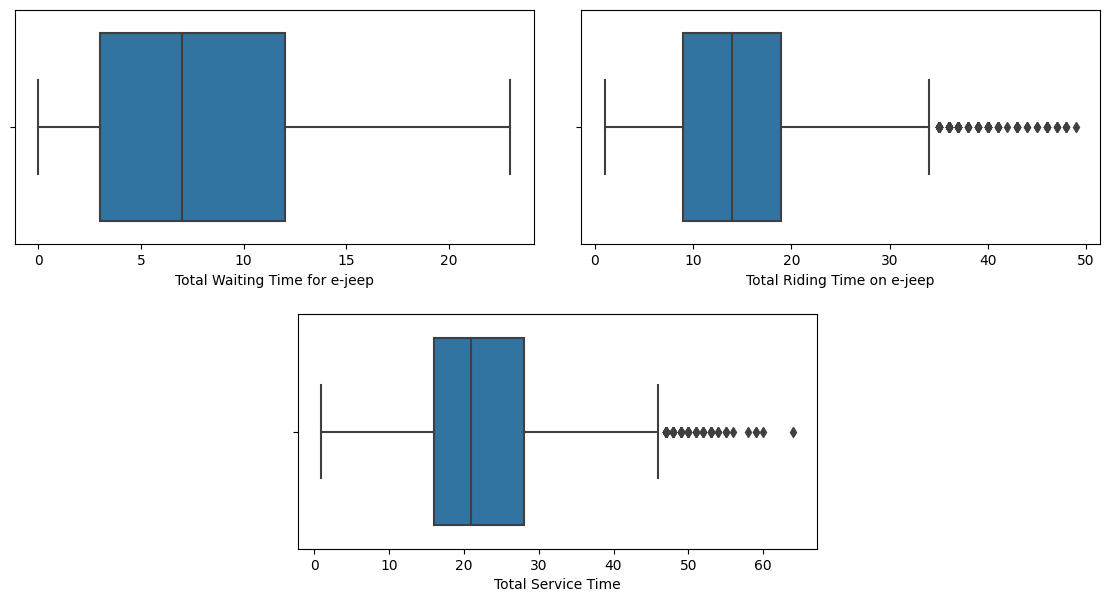

In [20]:
w, h = 2, 2
# fig, axes = plt.subplots(h, w, figsize=(14, 7))
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(2,4)

titles = {
    'total_waiting_time': "Total Waiting Time for e-jeep", 
    'total_riding_time': "Total Riding Time on e-jeep", 
    'total_service_time': "Total Service Time"
}

x, y = 0, 0
for i, c in enumerate(['total_waiting_time', 'total_riding_time', 'total_service_time']):
    # cur = res[res['origin_station'] == c]
    if i != 2:
      ax = plt.subplot(gs[y, 2*x:2*(x+1)])
    else:
      ax = plt.subplot(gs[y, 1:3])
    sns.boxplot(ax=ax, x=c, data=res, orient='h')
    ax.set(xlabel=f"{titles[c]}")
    if x == w-1: x = 0; y += 1 
    else: x += 1

fig.subplots_adjust(hspace=0.3, wspace=0.2)
# plt.delaxes(axes[1, 1])
# handles, labels = axes[h-1,w-2].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center')
plt.show()

The following shows a boxplot of the total service time for each pair of origin station and destination stations.

No passengers from Station 5


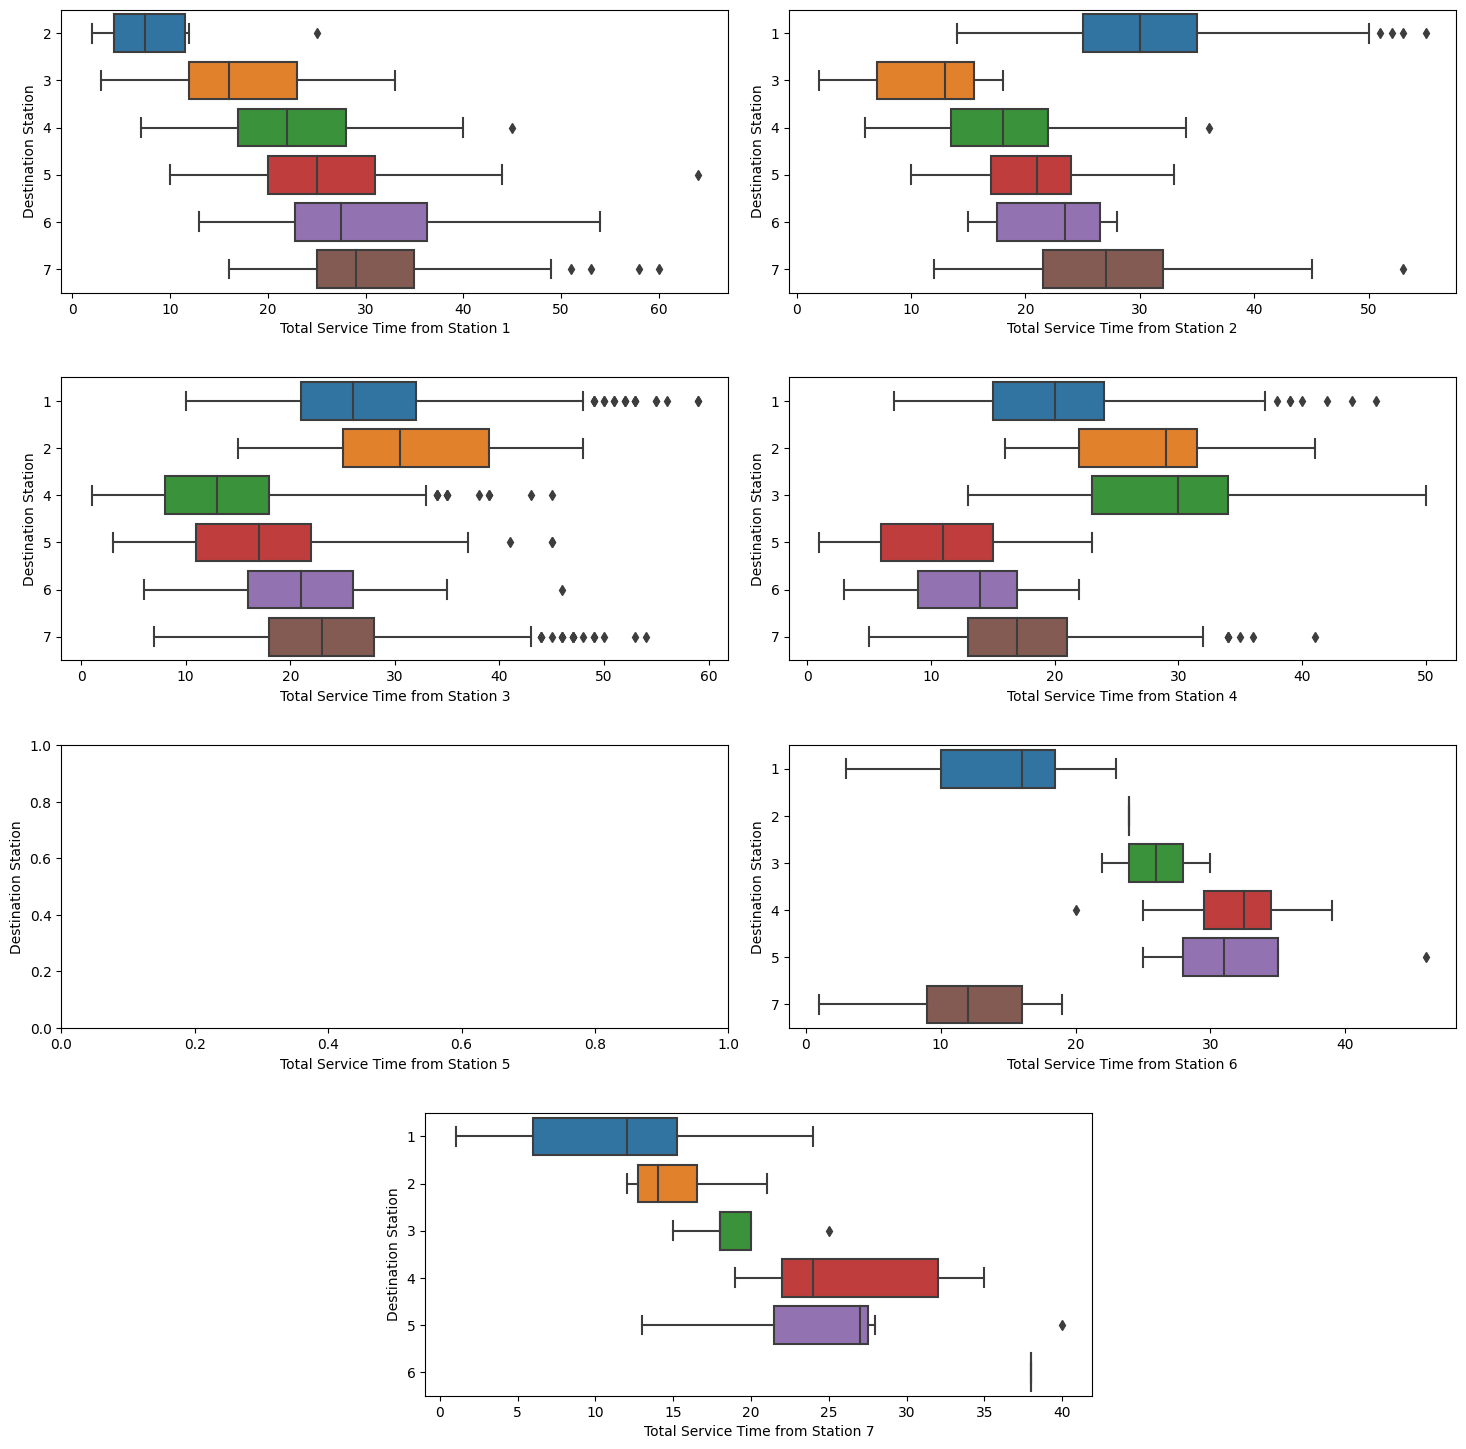

In [24]:
w, h = 2, 4
# fig, axes = plt.subplots(h, w, figsize=(18, 18))
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(4,4)

x, y = 0, 0
for c in range(1,8):
    if c != 7:
      ax = plt.subplot(gs[y, 2*x:2*(x+1)])
    else:
      ax = plt.subplot(gs[y, 1:3])

    cur = res[res['origin_station'] == c]
    try:
      sns.boxplot(ax=ax, x='total_service_time', y='destination_station', data=cur, orient='h')
    except:
      print(f"No passengers from Station {c}")
    ax.set(ylabel='Destination Station', xlabel=f"Total Service Time from Station {c}")
    if x == w-1: x = 0; y += 1 
    else: x += 1

fig.subplots_adjust(hspace=0.3, wspace=0.2)
# plt.delaxes(axes[3, 1])
# handles, labels = axes[h-1,w-2].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center')
plt.show()

# V. Preliminary Analysis
We notice the following for each origin station.
1. **Xavier Hall** - The longest total service time is to Leong Hall (as expected) with a median of about 30 minutes. The median total service times to the other stations station were around 10 minutes to 25 minutes.
2. **Old Comm** - The median total service times are more varried between 10 and 30 minutes with the stops further from the station having the longer total wait time. 
3. **Hagdan na Bato** - The total service times are more spread out, but the medians of the next stations (Grade School, JSEC, and Gate 2.5) are between 10 and 20 minutes. The rest stations of interest are above 20 minutes (Leong Hall and Xavier Hall).
4. **Grade School** - The total service time to JSEC and Gate 2.5 are expectedly short given the proximity. However, going to Leong and Xavier Hall takes more time with the median totla service times at around 17 and 20 minutes respectively.
5. **JSEC** - The average spawn time at JSEC was found to be 0 for both days. The JSEC station used to be a special rainstop but was eventually included. This could also be a result of JSEC having the lowest average wait time of the ejeep till departure of 0.04 minutes. More activity might be expected from JSEC at different times (ie. afternoon).
6. **Gate 2.5** - Only a few passengers ride from here. Getting to the next nearest stations of Leong Hall and Xavier Hall entail median total service times of 9 minutes and about 15 minutes respectively. Getting to the other stations takes more time (over 25 minutes).
7. **Leong Hall** - Similar to previous trends, getting to the next nearest station of Xavier Hall takes much less time with a median total service time of about 10 minutes. Getting to Hagdan takes between 10 and 20 minutes while the remaining stopes take more than 20 minutes on average. 

Overall, we only see the 10 minute total service times for stations that are immediately after or very close to the current station. Answering the question "Should I wait for the e-jeep" thus depends on the amount of time that a person is willing to wait for. The ideal service time of 10-15 minutes only occurs when your target station is the station directly after. Further stations may require more time, some even reaching 40-50 minutes, which could mean that walking should be considered. This may not be an option though for wider distances (especially coming from Hagdan na Bato).